In [1]:
%matplotlib inline

import os
import math
import numpy as np
import imageio
from matplotlib import pyplot as plt
from IPython.display import clear_output
import cv2
from PIL import Image, ImageFont, ImageDraw

import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'/opt/homebrew/bin/tesseract'

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
from art.estimators.classification import BlackBoxClassifier
from art.defences.preprocessor import JpegCompression
from art.attacks.evasion import HopSkipJump
from art.utils import to_categorical

In [33]:
def create_OCR_image(text):
    image_size = (150, 50)
    img_colour = (255, 255, 255)
    img = Image.new('RGB', image_size, color=img_colour)
    image_editable = ImageDraw.Draw(img)
    text_colour = (0, 0, 0)
    text_font_size = 15.652173913043478
    text_font = ImageFont.truetype('./fonts/raleway/Raleway-Bold.ttf', text_font_size)
    image_editable.text((0,-16), text, fill=text_colour, font=text_font)
    img = np.array(img)
    plt.imshow(img)
    return img

def predict(x):
    out_label = []
    for x_i in x:
        x_i = x_i.astype(np.uint8)
        out_string = pytesseract.image_to_string(x_i).strip()
#         print('`'+out_string+'`')
        if out_string:
            out_string = out_string.split()[0]
        if out_string == 'cant':
            out_label.append(0)
        elif out_string == 'can':
            out_label.append(1)
        else:
            out_label.append(2)
    out_label_cat = to_categorical(out_label, 3)
    return out_label_cat

def predict_text(model, image, label_dict):
    plt.imshow(image[:,:,0])
    plt.show()
    image_lst = np.array([image], dtype=np.float32)
    out_label_cat = model.predict(image_lst)
    print(label_dict[np.argmax(out_label_cat)])
    
def create_mask(model, image_init, image_target, label_dict):
    attack = HopSkipJump(classifier=model, targeted=True, norm=2, max_iter=0, max_eval=1000, init_eval=10)
    iter_step = 10
    l2_error_lst = []
    x_adv = np.array([image_init], dtype=np.float32)
    for i in range(15):
        x_adv = attack.generate(x=np.array([image_target], dtype=np.float32), x_adv_init=x_adv, y=to_categorical([1], 3))
        l2_error = np.linalg.norm(np.reshape(x_adv[0]-image_target,[-1]))
        l2_error_lst.append(l2_error)
        print("Adversarial image at step %d." % (i*iter_step))
        print("L2 error: %.6f" %l2_error)
        print("Tesseract output is: %s." % label_dict[np.argmax(model.predict(x_adv)[0])])
        plt.imshow(x_adv[0,:,:,0])
        plt.show(block=False)
        attack.max_iter = iter_step
        if i>=1 and abs(l2_error_lst[-2]-l2_error_lst[-1])/l2_error_lst[-2]<0.01:
            break
    return x_adv, l2_error_lst

In [ ]:
#Text that you want the model to read
init_word = 'can'
#Text that you want to show on the image
target_word = 'cant'
label_dict = {0: target_word, 1: init_word, 2: 'other'}

image_init = create_OCR_image(init_word)
image_target = create_OCR_image(target_word)


model = BlackBoxClassifier(predict, image_target.shape, 3, clip_values=(0, 255))
predict_text(model, image_init, label_dict)
predict_text(model, image_target, label_dict)

HopSkipJump: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1804.78it/s]


Adversarial image at step 0.
L2 error: 4186.825195
Tesseract output is: can.


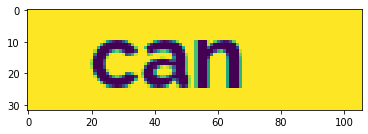

HopSkipJump: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:38<00:00, 38.74s/it]


Adversarial image at step 10.
L2 error: 2282.255859
Tesseract output is: can.


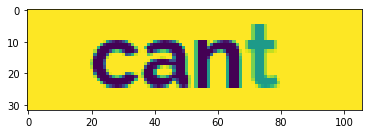

HopSkipJump: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:42<00:00, 42.13s/it]


Adversarial image at step 20.
L2 error: 2282.256104
Tesseract output is: can.


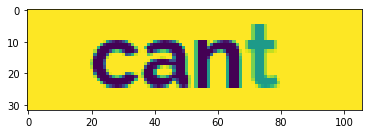

In [9]:
adv_img, l2_error_lst = create_mask(model, image_init, image_target, label_dict)

After perturbation


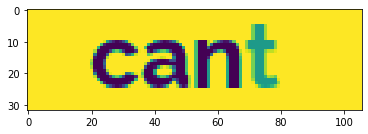

Tesseract output: can



In [10]:
# Verify

adv_img_copy = adv_img.astype(np.uint8)
plt.imshow(adv_img_copy[0,:,:,0])
print('After perturbation')
plt.show()
print("Tesseract output: "+pytesseract.image_to_string(adv_img_copy[0,:,:,0]))